In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import seaborn as sns
import warnings
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

In [2]:
df_tr = pd.read_csv('train.csv')
df_tr.head()

,bully,tweet,individual,group,gender,physical,race,religion
0,no,USER terimakasih Ustadz sudah bersuara tentang...,0,0,0,0,0,0
1,no,USER USER Maaf sebenarnya twiter pertama kali ...,0,0,0,0,0,0
2,yes,USER Anjing tai goblok idiot bangsat monyet ba...,1,0,1,1,0,0
3,no,"Hadiri Lokakarya Kebudayaan Daerah, Bupati Rup...",0,0,0,0,0,0
4,yes,USER USER USER yg kaya gini layak di tangkap.,1,0,0,0,0,0


In [3]:
df_tr['bully'].value_counts() # cukup balance

no     6114
yes    4421
Name: bully, dtype: int64

In [4]:
df_te = pd.read_csv('test.csv')
df_te.head()

,id,bully,tweet
0,o66172,NaN,"41. Kadang aku berfikir, kenapa aku tetap perc..."
1,s9818,NaN,"Setidaknya gw punya jari tengah buat lu, sebel..."
2,n96529,NaN,Belakangan ini kok fikiran ampas banget ya'
3,c86722,NaN,Dari habis sahur sampe jam 10. Sibayik udah ne...
4,j28486,NaN,USER USER Presiden RI Jokowi luarBiasa kerja n...


In [5]:
# stopwords = kata-kata uyg sering muncul, tp artinya tdk terlalu berpengaruh
with open("stopword_nonltk.pkl", 'rb') as file:
  stopwords = pickle.load(file) 

In [6]:
stopwords[:8]

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan']

In [7]:
# meaningless = sama sekali tidak memiliki makna
meaningless = pd.read_csv('meaningless.csv', header=None)
meaningless = meaningless.iloc[:,0].tolist()
meaningless[:3]

['aduh', 'ah', 'alah']

In [8]:
# normalisasi
normalization = pd.read_csv('kamus_normalisasi.csv', header=None)
normalization.columns = ['before', 'after']
normalization.head()

,before,after
0,27-Jun,dua puluh tujuh juni
1,01curang,01 curang
2,01thechampion,01 the champion
3,02wintheelection,02 win the election
4,½ramayana,ramayana


In [9]:
normalization['before'].tolist()[:4]

['27-Jun', '01curang', '01thechampion', '02wintheelection']

Preprocess

In [10]:
# lower case
df_tr['tweet'] = df_tr['tweet'].str.lower()
df_tr.head()

,bully,tweet,individual,group,gender,physical,race,religion
0,no,user terimakasih ustadz sudah bersuara tentang...,0,0,0,0,0,0
1,no,user user maaf sebenarnya twiter pertama kali ...,0,0,0,0,0,0
2,yes,user anjing tai goblok idiot bangsat monyet ba...,1,0,1,1,0,0
3,no,"hadiri lokakarya kebudayaan daerah, bupati rup...",0,0,0,0,0,0
4,yes,user user user yg kaya gini layak di tangkap.,1,0,0,0,0,0


In [11]:
# normalisasi kata
def normalization_text(txt):
  nonstdr = normalization['before'].tolist()
  stdr = normalization['after'].tolist()
  list_before = txt.split()
  for i in list_before:
    if i in nonstdr:
      index = nonstdr.index(i)
      list_before[list_before.index(i)] = stdr[index]
  return " ".join(list_before)
df_tr['tweet'] = df_tr['tweet'].apply(lambda x: normalization_text(x))
df_tr.head()

,bully,tweet,individual,group,gender,physical,race,religion
0,no,user terima kasih ustaz sudah bersuara tentang...,0,0,0,0,0,0
1,no,user user maaf sebenarnya twitter pertama kali...,0,0,0,0,0,0
2,yes,user anjing tai goblok idiot bangsat monyet ba...,1,0,1,1,0,0
3,no,"hadiri lokakarya kebudayaan daerah, bupati rup...",0,0,0,0,0,0
4,yes,user user user yang kaya begini layak di tangkap.,1,0,0,0,0,0


In [12]:
# meaningless
def remove_meaningless(txt):
  list_before = txt.split()
  list_after = [x for x in list_before if x not in meaningless]
  return " ".join(list_after)
df_tr['tweet'] = df_tr['tweet'].apply(lambda x : remove_meaningless(x))
df_tr.head()

,bully,tweet,individual,group,gender,physical,race,religion
0,no,terima kasih ustaz sudah bersuara tentang radi...,0,0,0,0,0,0
1,no,maaf sebenarnya twitter pertama kali dibuat bu...,0,0,0,0,0,0
2,yes,anjing tai goblok idiot bangsat monyet babi fu...,1,0,1,1,0,0
3,no,"hadiri lokakarya kebudayaan daerah, bupati rup...",0,0,0,0,0,0
4,yes,kaya begini layak di tangkap.,1,0,0,0,0,0


In [13]:
# stopwords
def remove_stopwords(txt):
  list_before = txt.split()
  list_after = [x for x in list_before if x not in stopwords]
  return " ".join(list_after)
df_tr['tweet'] = df_tr['tweet'].apply(lambda x : remove_stopwords(x))
df_tr.head()

,bully,tweet,individual,group,gender,physical,race,religion
0,no,terima kasih ustaz bersuara radikal radikal in...,0,0,0,0,0,0
1,no,maaf twitter kali orang bego',0,0,0,0,0,0
2,yes,anjing tai goblok idiot bangsat monyet babi fu...,1,0,1,1,0,0
3,no,"hadiri lokakarya kebudayaan daerah, bupati rup...",0,0,0,0,0,0
4,yes,kaya layak tangkap.,1,0,0,0,0,0


In [14]:
# removing punctuations
def remove_punctuation(txt):
  return txt.translate(str.maketrans('','',string.punctuation))
df_tr['tweet'] = df_tr['tweet'].apply(lambda x: remove_punctuation(x))
df_tr.head(10)

,bully,tweet,individual,group,gender,physical,race,religion
0,no,terima kasih ustaz bersuara radikal radikal in...,0,0,0,0,0,0
1,no,maaf twitter kali orang bego,0,0,0,0,0,0
2,yes,anjing tai goblok idiot bangsat monyet babi fu...,1,0,1,1,0,0
3,no,hadiri lokakarya kebudayaan daerah bupati rupi...,0,0,0,0,0,0
4,yes,kaya layak tangkap,1,0,0,0,0,0
5,yes,namanya memancing konflik horizontal polisi me...,1,0,0,0,0,0
6,no,wonu oppa matanya sipit banget,0,0,0,0,0,0
7,yes,smartfren jaringan berengsek,0,1,0,0,0,0
8,yes,pret kampret tidak dukung 2019 ganti presiden...,1,0,0,0,0,0
9,yes,sombong punuk onta,1,0,0,0,0,0


In [15]:
df_te['tweet'] = df_te['tweet'].str.lower()
df_te['tweet'] = df_te['tweet'].apply(lambda x: normalization_text(x))
df_te['tweet'] = df_te['tweet'].apply(lambda x: remove_meaningless(x))
df_te['tweet'] = df_te['tweet'].apply(lambda x: remove_stopwords(x))
df_te['tweet'] = df_te['tweet'].apply(lambda x: remove_punctuation(x))

In [16]:
df_te.head()

,id,bully,tweet
0,o66172,NaN,41 kadang aku berfikir aku percaya tuhan aku j...
1,s9818,NaN,aku jari lu aku ukur nyali bacot kamu
2,n96529,NaN,pikiran ampas banget ya
3,c86722,NaN,habis sahur jam 10 si bayi nete 4x lemas tidak
4,j28486,NaN,presiden republik indonesia jokowi kerja tulus...


EDA

In [17]:
df_tr['bully'].value_counts()

no     6114
yes    4421
Name: bully, dtype: int64

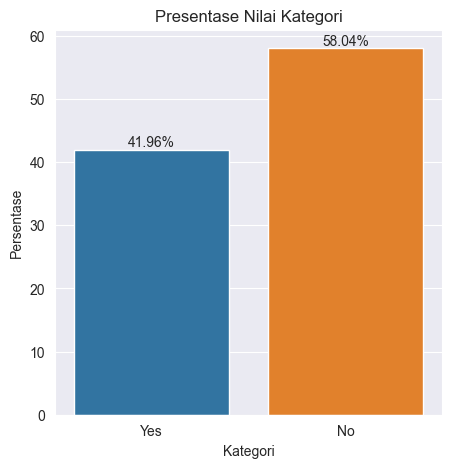

In [18]:
data = {'Yes': df_tr[df_tr['bully'] == 'yes']['bully'].count(), 'No': df_tr[df_tr['bully'] == 'no']['bully'].count()}
total = sum(data.values())
persentase = [(value / total) * 100 for value in data.values()]
df = pd.DataFrame({'Kategori': data.keys(), 'Persentase': persentase})
plt.figure(figsize=(5, 5))
sns.set_style('darkgrid')
ax = sns.barplot(x='Kategori', y='Persentase', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', xytext=(0, 0), textcoords='offset points')
ax.set_xlabel('Kategori')
ax.set_ylabel('Persentase')
ax.set_title('Presentase Nilai Kategori')

plt.show()

In [19]:
df_tr.columns

Index(['bully', 'tweet', 'individual', 'group', 'gender', 'physical', 'race',
       'religion'],
      dtype='object')

In [20]:
df_tr[df_tr['individual'] == 1]['individual'].count()

2848

In [21]:
col_name = df_tr.columns[2:8]
mydict = {}

In [22]:
for col in col_name:
  mydict[col] =  df_tr[df_tr[col] == 1][col].count()
data = dict(sorted(mydict.items(), key=lambda x: x[1], reverse=False))
data

{'gender': 245,
 'physical': 255,
 'race': 433,
 'religion': 626,
 'group': 1573,
 'individual': 2848}

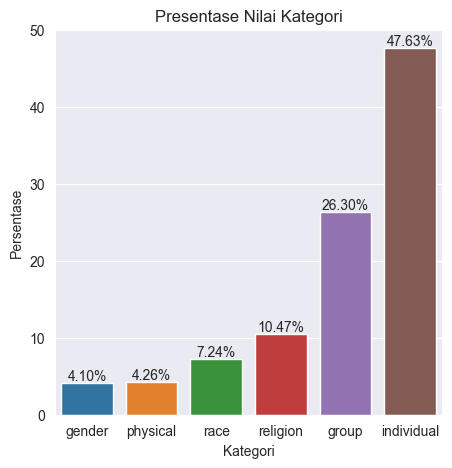

In [23]:
total = sum(data.values())
persentase = [(value / total) * 100 for value in data.values()]
df = pd.DataFrame({'Kategori': data.keys(), 'Persentase': persentase})
plt.figure(figsize=(5, 5))
sns.set_style('darkgrid')
ax = sns.barplot(x='Kategori', y='Persentase', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', xytext=(0, 0), textcoords='offset points')
ax.set_xlabel('Kategori')
ax.set_ylabel('Persentase')
ax.set_title('Presentase Nilai Kategori')

plt.show()

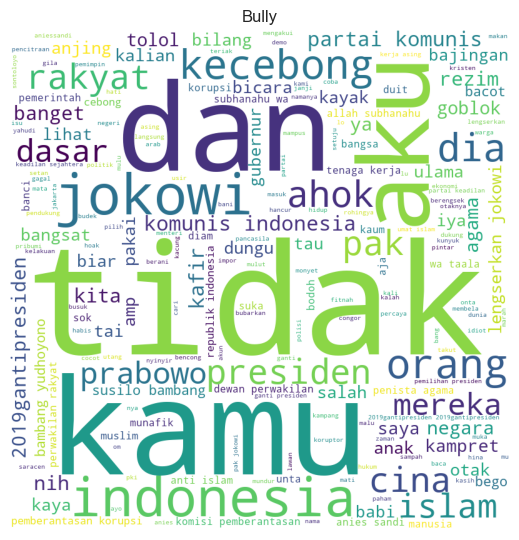

In [24]:
from wordcloud import WordCloud
text = " ".join(x for x in df_tr[df_tr['bully']=='yes']['tweet'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text)
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Bully') 
plt.show()

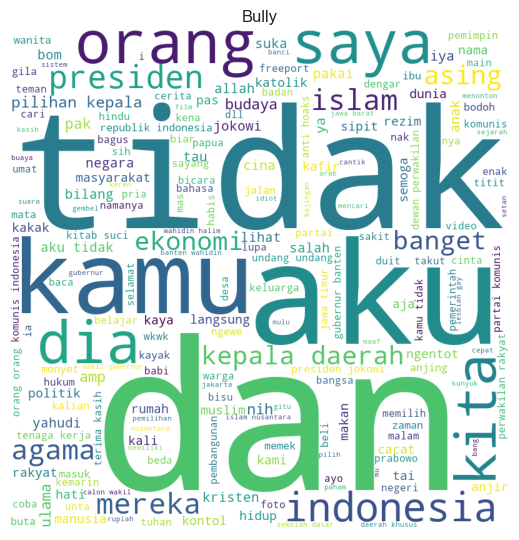

In [25]:
from wordcloud import WordCloud
text = " ".join(x for x in df_tr[df_tr['bully']=='no']['tweet'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text)
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Bully') 
plt.show()

Modeling

In [26]:
df_tr

,bully,tweet,individual,group,gender,physical,race,religion
0,no,terima kasih ustaz bersuara radikal radikal in...,0,0,0,0,0,0
1,no,maaf twitter kali orang bego,0,0,0,0,0,0
2,yes,anjing tai goblok idiot bangsat monyet babi fu...,1,0,1,1,0,0
3,no,hadiri lokakarya kebudayaan daerah bupati rupi...,0,0,0,0,0,0
4,yes,kaya layak tangkap,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
10530,yes,lahir bicara soeharto l keahlian kecebong 1 tu...,0,1,0,0,0,0
10531,yes,pencitraan luahprabowo tidur,1,0,0,0,0,0
10532,yes,kecebong tukang ngamuk,0,1,0,0,0,0
10533,yes,prof kaum kambing bengek begitu beda dibilang ...,0,1,0,0,0,0


In [27]:
df_ = df_tr[['bully','tweet']].copy()

In [28]:
df_['bullying']= np.where(df_['bully'] == 'yes', 1, 0)

In [29]:
df_

,bully,tweet,bullying
0,no,terima kasih ustaz bersuara radikal radikal in...,0
1,no,maaf twitter kali orang bego,0
2,yes,anjing tai goblok idiot bangsat monyet babi fu...,1
3,no,hadiri lokakarya kebudayaan daerah bupati rupi...,0
4,yes,kaya layak tangkap,1
...,...,...,...
10530,yes,lahir bicara soeharto l keahlian kecebong 1 tu...,1
10531,yes,pencitraan luahprabowo tidur,1
10532,yes,kecebong tukang ngamuk,1
10533,yes,prof kaum kambing bengek begitu beda dibilang ...,1


In [30]:
train, test = train_test_split(df_, test_size=0.2, random_state = 23)
list_classes = 'bullying'
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["tweet"]
list_sentences_test = test["tweet"]

In [31]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [32]:
coba =[]
for i in df_['tweet']:
  mylist = i.split()
  coba.append(len(mylist))
maxlen = max(coba)

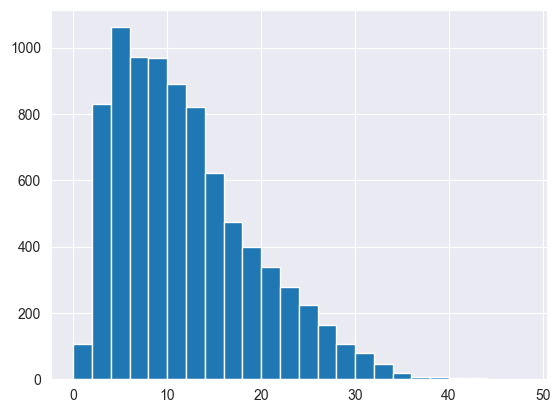

In [33]:
X_t = pad_sequences(tokenized_train, maxlen=maxlen)
X_te = pad_sequences(tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,maxlen,2))
plt.show()

In [34]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [35]:
max_vocab_length = 10000 
max_length = maxlen
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [36]:
text_vectorizer.adapt(list_sentences_train)

In [37]:
sample_sentence = "Kamu tidak paham bagaimana berpolitik"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 49), dtype=int64, numpy=
array([[   5,    2,  151, 7512, 2139,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int64)>

In [38]:
embedding = layers.Embedding(10000, 128, input_length=500)

In [39]:
import tensorflow as tf

In [40]:
#setting callback
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.80:
      print("\nTraining was stopped. Got:")
      self.model.stop_training = True

callbacks = callback()
     

In [41]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dropout(0.1)(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = tf.keras.Model(inputs, outputs, name='Model')

In [42]:
model1.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 49)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 49, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 49, 64)           41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                             

In [43]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
     

In [44]:
history = model1.fit(list_sentences_train,
                    y,
                    epochs=100,
                    validation_data=(list_sentences_test, y_te),
                    callbacks=[callbacks])

Epoch 1/100
264/264 [==============================] - 12s 24ms/step - loss: 0.5442 - accuracy: 0.7135 - val_loss: 0.3872 - val_accuracy: 0.8272
Epoch 2/100
264/264 [==============================] - 6s 21ms/step - loss: 0.2934 - accuracy: 0.8876 - val_loss: 0.3893 - val_accuracy: 0.8282
Epoch 3/100
264/264 [==============================] - 6s 21ms/step - loss: 0.1737 - accuracy: 0.9375 - val_loss: 0.4607 - val_accuracy: 0.8230
Epoch 4/100
263/264 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9623
Training was stopped. Got:
264/264 [==============================] - 6s 21ms/step - loss: 0.1090 - accuracy: 0.9624 - val_loss: 0.7325 - val_accuracy: 0.8239


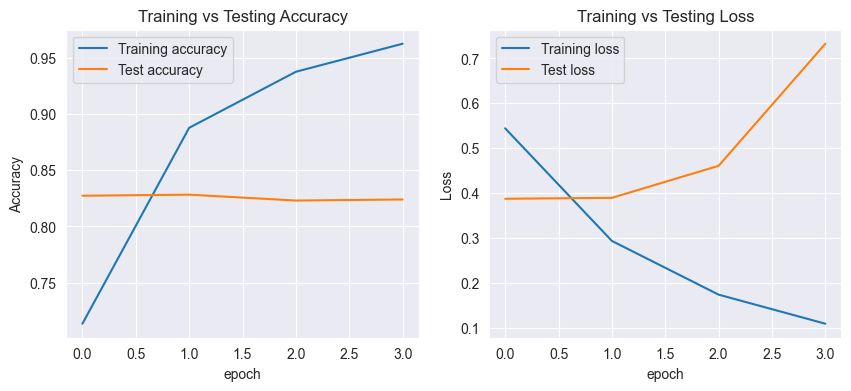

In [45]:
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Test loss')
plt.title('Training vs Testing Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
weights = model1.get_layer('embedding').get_weights()[0]
weights.shape

(10000, 128)

In [47]:
y_pred1 = tf.round(model1.predict(list_sentences_test))
y_pred1

66/66 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(2107, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)>

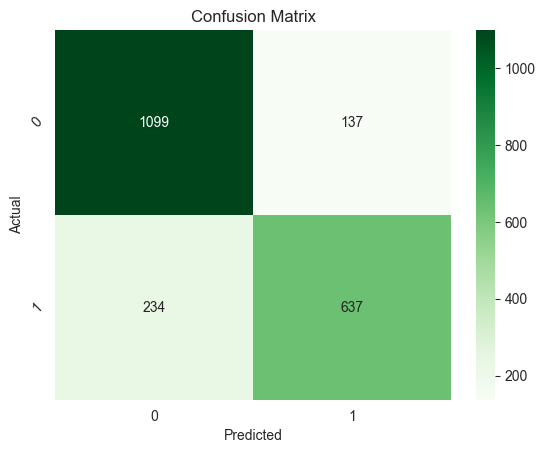

In [48]:
#Result (Confusion Matric)
target_names = ['0','1']

import seaborn as sn
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_te, y_pred1)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,ax=ax, cmap=plt.cm.Greens,fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names,rotation = 45)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
from sklearn.metrics import classification_report

In [50]:
print(classification_report(y_te, y_pred1))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1236
           1       0.82      0.73      0.77       871

    accuracy                           0.82      2107
   macro avg       0.82      0.81      0.82      2107
weighted avg       0.82      0.82      0.82      2107



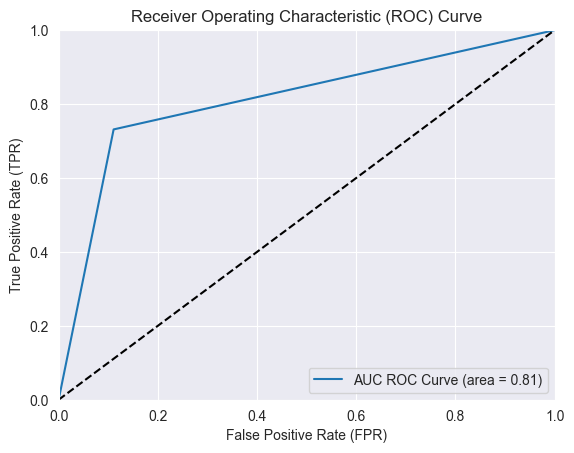

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Hitung skor AUC ROC
auc_roc_score = roc_auc_score(y_te, y_pred1)

# Hitung nilai false positive rate (FPR), true positive rate (TPR) dan threshold
fpr, tpr, thresholds = roc_curve(y_te, y_pred1)

# Gambar AUC ROC Curve
plt.plot(fpr, tpr, label='AUC ROC Curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [58]:
real_test = df_te.copy()
test_sentences = real_test['tweet']
model1_predict = tf.round(model1.predict(test_sentences))
model1_predict

83/83 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(2634, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)>

In [59]:
real_test['prediksi_label'] = model1_predict
real_test

,id,bully,tweet,prediksi_label
0,o66172,NaN,41 kadang aku berfikir aku percaya tuhan aku j...,0.0
1,s9818,NaN,aku jari lu aku ukur nyali bacot kamu,1.0
2,n96529,NaN,pikiran ampas banget ya,0.0
3,c86722,NaN,habis sahur jam 10 si bayi nete 4x lemas tidak,0.0
4,j28486,NaN,presiden republik indonesia jokowi kerja tulus...,0.0
...,...,...,...,...
2629,h68257,NaN,tidak kasihan ya pasukan nasi bungkus baju kot...,0.0
2630,f25841,NaN,user foto 3 pohon koloni monyet putih aku tida...,0.0
2631,b71622,NaN,rizieq shihab front pembela islam jancuk anjin...,1.0
2632,r48999,NaN,berengsek orang terbuat aku kasar mulu,0.0


### Using Pretained model

In [60]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [61]:
from gensim.models import Word2Vec

model = Word2Vec.load("wiki.id.case.model")
model.wv.save_word2vec_format("model_file.bin", binary=True)

In [62]:
def create_fold_embeddings(embeddings_dim, key_vector):
    emb_init_values = np.zeros((len(tokenizer.word_index) + 1, embeddings_dim))
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():
        if word == '<unk>':
            emb_init_values[i] = np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32')

        elif word == '<pad>':
            emb_init_values[i] = np.zeros(embeddings_dim).astype('float32')
                    
        elif word in key_vector.key_to_index:
            emb_init_values[i] = key_vector.get_vector(word)
            b = b+1
        else:
            emb_init_values[i] = np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32')
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values[len(tokenizer.word_index)] = np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32')
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values


In [63]:
#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("model_file.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 400

loading word2vec...


In [64]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

11846 6967
known words: 11846
unknown words: 6967


In [65]:
emb_init_values.shape

(18814, 400)

In [66]:
inp = Input(shape=(maxlen,))
inp

<KerasTensor: shape=(None, 49) dtype=float32 (created by layer 'input_2')>

In [67]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 50

# file_path="weights_base.best.hdf5"
#RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
history = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[callbacks], verbose=2, validation_data=(X_te, y_te))

Epoch 1/50


c:\Users\fadel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


264/264 - 11s - loss: 0.4687 - accuracy: 0.7757 - val_loss: 0.3733 - val_accuracy: 0.8348 - 11s/epoch - 43ms/step
Epoch 2/50
264/264 - 7s - loss: 0.2169 - accuracy: 0.9154 - val_loss: 0.4345 - val_accuracy: 0.8253 - 7s/epoch - 26ms/step
Epoch 3/50

Training was stopped. Got:
264/264 - 7s - loss: 0.0929 - accuracy: 0.9678 - val_loss: 0.5516 - val_accuracy: 0.8102 - 7s/epoch - 26ms/step


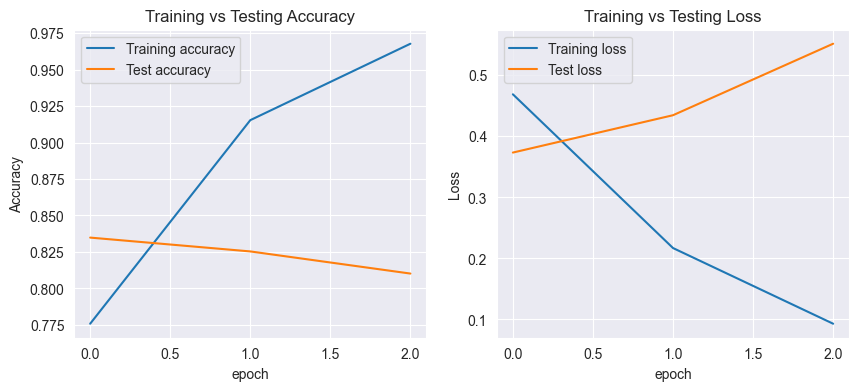

In [68]:
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Test loss')
plt.title('Training vs Testing Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [69]:
y_pred = tf.round(model.predict(X_te))
y_pred

66/66 [==============================] - 2s 12ms/step


<tf.Tensor: shape=(2107, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)>

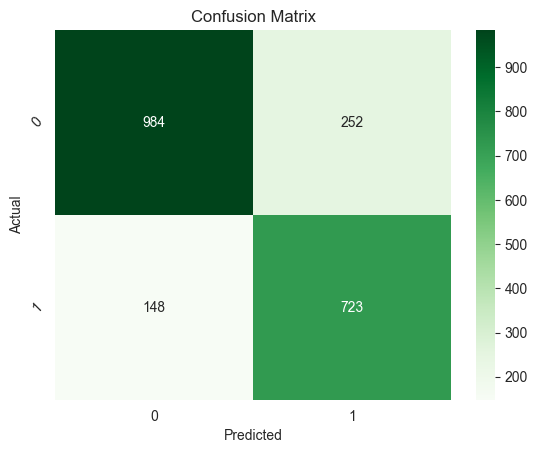

In [70]:
#Result (Confusion Matric)
target_names = ['0','1']

import seaborn as sn
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_te, y_pred)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,ax=ax, cmap=plt.cm.Greens,fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names,rotation = 45)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [71]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1236
           1       0.74      0.83      0.78       871

    accuracy                           0.81      2107
   macro avg       0.81      0.81      0.81      2107
weighted avg       0.82      0.81      0.81      2107



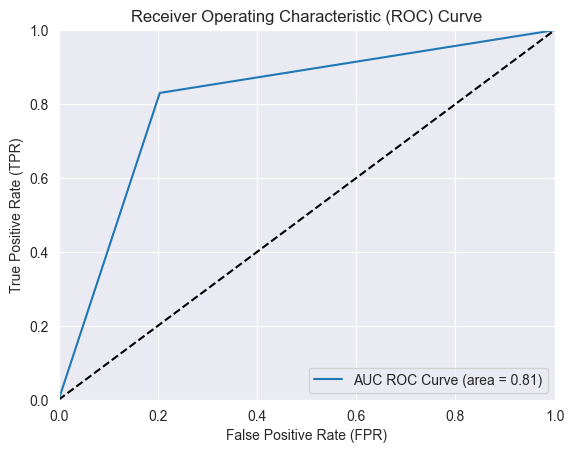

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Hitung skor AUC ROC
auc_roc_score = roc_auc_score(y_te, y_pred)

# Hitung nilai false positive rate (FPR), true positive rate (TPR) dan threshold
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

# Gambar AUC ROC Curve
plt.plot(fpr, tpr, label='AUC ROC Curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [81]:
real_test2 = df_te.copy()
test_sentences2 = real_test2['tweet']
test_seq = tokenizer.texts_to_sequences(test_sentences2)
padded = pad_sequences(test_seq)

In [89]:
real_test2['prediksi_label'] = tf.round(model.predict(padded))

83/83 [==============================] - 1s 11ms/step


In [90]:
real_test2

,id,bully,tweet,prediksi_label
0,o66172,NaN,41 kadang aku berfikir aku percaya tuhan aku j...,0.0
1,s9818,NaN,aku jari lu aku ukur nyali bacot kamu,1.0
2,n96529,NaN,pikiran ampas banget ya,1.0
3,c86722,NaN,habis sahur jam 10 si bayi nete 4x lemas tidak,0.0
4,j28486,NaN,presiden republik indonesia jokowi kerja tulus...,0.0
...,...,...,...,...
2629,h68257,NaN,tidak kasihan ya pasukan nasi bungkus baju kot...,0.0
2630,f25841,NaN,user foto 3 pohon koloni monyet putih aku tida...,0.0
2631,b71622,NaN,rizieq shihab front pembela islam jancuk anjin...,1.0
2632,r48999,NaN,berengsek orang terbuat aku kasar mulu,1.0
